In [ ]:
!pip install tensorflow_similarity==0.17.1
!pip install tensorflow_addons

In [2]:
import random
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_similarity as tfsim
import numpy as np
np.set_printoptions(precision=4)
np.set_printoptions(threshold=np.inf)
np.set_printoptions(linewidth=np.inf)
np.set_printoptions(suppress=True)

from scipy.special import erf
def IVcurve(x, Vx, Phi, Ti, Of):
    Vsc=7545
    pi=3.1415926
    q=1.6e-19
    k=1.38e-23
    mH=1.67262177774e-27
    mHe=(1.67262177774e-27)*4
    mO=(1.67262177774e-27)*16

    b_H= np.sqrt(mH/(2*k*Ti))
    b_He=np.sqrt(mHe/(2*k*Ti))
    b_O= np.sqrt(mO/(2*k*Ti))

    f_H= Vsc-Vx-np.sqrt( (2*q/mH)* (0.5+0.5*np.tanh(1e+19*(x+Phi))) * (x+Phi) )
    f_He=Vsc-Vx-np.sqrt( (2*q/mHe)*(0.5+0.5*np.tanh(1e+19*(x+Phi))) * (x+Phi) )
    f_O= Vsc-Vx-np.sqrt( (2*q/mO)* (0.5+0.5*np.tanh(1e+19*(x+Phi))) * (x+Phi) )

    IV= lambda b,f :0.5* (1 + erf(b*f) + np.exp(-b*b*f*f)/(np.sqrt(pi)*b*(Vsc-Vx) ))
    return (1-Of)*IV(b_H,f_H)+ Of*IV(b_O,f_O)

rv=np.array([ 0. ,  0.4,  0.7,  0.9,  1.1,  1.2,  1.3,  1.4,  1.6,  1.8,  2.2,
             2.5,  2.9,  3.2,  3.6,  3.9,  4.2,  4.5,  4.8,  5. ,  5.2,  5.4,
             5.8,  6.3,  6.9,  7.5,  8. ,  8.5, 10. , 10. , 10. , 10. ])

classes ={1:[300, -0.22, 1500, 0.2],
          2:[50, -1, 2000, 0.4],
          3:[-150, -1.5, 2900, 0.15],
          4:[-200, -2, 500, 0.6],
          5:[100, -0.5, 800, 0.9],
          6:[0, -0.75, 999, 0.55],
          7:[75, -0.1, 1234, 0.8],
          8:[-300, -1.7, 768, 0.6],
          9:[250, -1, 2135, 0.2],
          10:[168, -2, 3100, 0.05]}

LABELS = []
DATA = []
for n in random.choices(list(classes.keys()), k=30000):
    LABELS.append( n )
    noise = np.random.normal(0, 0.01, rv.shape[-1])
    DATA.append( IVcurve(rv, *classes[n]) + noise )
LABELS = np.array(LABELS)
DATA = np.array(DATA)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
query_idxs, index_idxs, train_idxs = [], [], []
for cid in range(len(classes)):
    idxs = tf.random.shuffle(tf.where(LABELS == cid))
    idxs = tf.reshape(idxs, (-1,))
    query_idxs.extend(idxs[:100])  # 100 query examples per class
    index_idxs.extend(idxs[100:200])  # 100 index examples per class
    train_idxs.extend(idxs[200:])  # The remaining are used for training

random.shuffle(query_idxs)
random.shuffle(index_idxs)
random.shuffle(train_idxs)

x_query, y_query = DATA[query_idxs], LABELS[query_idxs]
x_index, y_index = DATA[index_idxs], LABELS[index_idxs]
x_train, y_train = DATA[train_idxs], LABELS[train_idxs]

In [4]:
SEED = 26
BATCH_SIZE = 512

def custom_augment(y):
    PROB = 0.2
    return tf.nn.dropout(y, rate=PROB)*(1-PROB)

ssl_ds_one = tf.data.Dataset.from_tensor_slices(x_train)
ssl_ds_one = (
    ssl_ds_one.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

ssl_ds_two = tf.data.Dataset.from_tensor_slices(x_train)
ssl_ds_two = (
    ssl_ds_two.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# We then zip both of these datasets.
ssl_ds = tf.data.Dataset.zip((ssl_ds_one, ssl_ds_two))

In [8]:
def get_backbone(input_dim, channel=16):
    inputs = tf.keras.layers.Input((input_dim,), name="backbone_input")
    x = tf.expand_dims(inputs, axis=-1)
    x = tf.keras.layers.Conv1D(channel, kernel_size=3, strides=2, activation="relu")(x)
    x = tf.keras.layers.Conv1D(channel, kernel_size=3, strides=2, activation="relu")(x)
    x = tf.keras.layers.Conv1D(channel, kernel_size=3, strides=2, activation="relu")(x)
    x = tf.keras.layers.Conv1D(channel, kernel_size=3, strides=2, activation="relu")(x)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(channel, activation="relu", name="backbone_output")(x)
    return tf.keras.Model(inputs, outputs, name="backbone")

def get_projector(input_dim, embedding_size, activation="relu", num_layers: int = 3):
    inputs = tf.keras.layers.Input((input_dim,), name="projector_input")
    x = inputs
    for i in range(num_layers - 1):
        x = tf.keras.layers.Dense(embedding_size, use_bias=False, kernel_initializer=tf.keras.initializers.LecunUniform(), name=f"projector_layer_{i}")(x)
        x = tf.keras.layers.BatchNormalization(epsilon=1.001e-5, name=f"batch_normalization_{i}")(x)
        x = tf.keras.layers.Activation(activation, name=f"{activation}_activation_{i}")(x)
    x = tf.keras.layers.Dense(embedding_size, use_bias=False, kernel_initializer=tf.keras.initializers.LecunUniform(), name="projector_output")(x)
    x = tf.keras.layers.BatchNormalization(epsilon=1.001e-5, center=False, scale=False, name="batch_normalization_ouput")(x)
    outputs = tfsim.layers.ActivationStdLoggingLayer(name="proj_std")(x)
    return tf.keras.Model(inputs, outputs, name="projector")

TEMPERATURE = 0.25
INIT_LR = 1e-3
EMB_SIZE = 8

backbone = get_backbone( x_train.shape[-1], channel=16)
projector = get_projector( input_dim = backbone.output.shape[-1], embedding_size=EMB_SIZE, num_layers=2)

model = tfsim.models.ContrastiveModel(
    backbone = backbone,
    projector = projector,
    algorithm="simclr"
)

model.compile(
    optimizer = tfa.optimizers.LAMB(learning_rate=INIT_LR),
    loss = tfsim.losses.SimCLRLoss(name="simclr", temperature=TEMPERATURE)
)

history = model.fit(
    ssl_ds,
    epochs=10,
    callbacks=[
        tfsim.callbacks.EvalCallback(x_query, y_query, x_index, y_index, metrics=["binary_accuracy"], k=1)
    ]
)

Epoch 1/10
50/50 [==============================] - 9s 95ms/step - loss: 13.0750 - proj_std: 0.3516 - binary_accuracy: 1.0000
Epoch 2/10
50/50 [==============================] - 4s 69ms/step - loss: 11.2124 - proj_std: 0.3511 - binary_accuracy: 1.0000
Epoch 3/10
50/50 [==============================] - 3s 69ms/step - loss: 10.6137 - proj_std: 0.3508 - binary_accuracy: 1.0000
Epoch 4/10
50/50 [==============================] - 5s 95ms/step - loss: 10.3163 - proj_std: 0.3501 - binary_accuracy: 1.0000
Epoch 5/10
50/50 [==============================] - 3s 69ms/step - loss: 10.1181 - proj_std: 0.3501 - binary_accuracy: 1.0000
Epoch 6/10
50/50 [==============================] - 4s 71ms/step - loss: 9.9824 - proj_std: 0.3508 - binary_accuracy: 1.0000
Epoch 7/10
50/50 [==============================] - 3s 68ms/step - loss: 9.8901 - proj_std: 0.3518 - binary_accuracy: 1.0000
Epoch 8/10
50/50 [==============================] - 3s 69ms/step - loss: 9.8101 - proj_std: 0.3523 - binary_accuracy: 1.

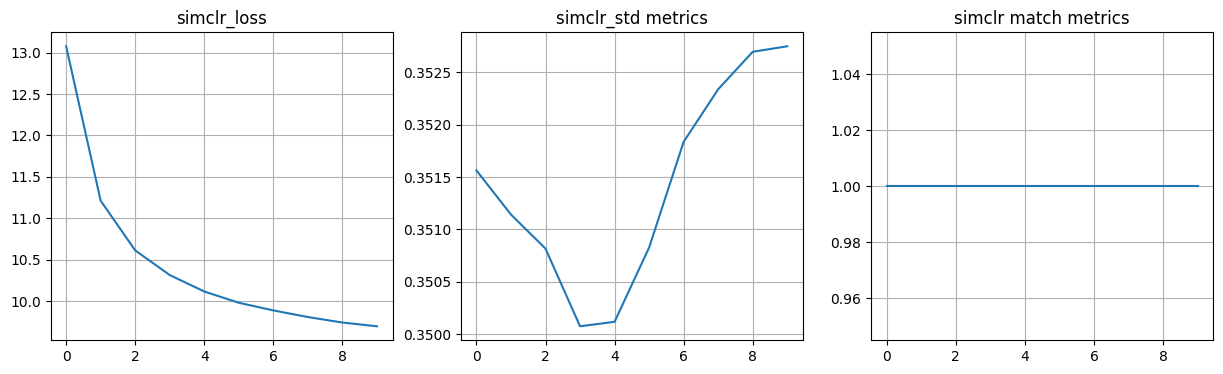

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(history.history["loss"])
plt.grid()
plt.title("simclr_loss")

plt.subplot(1,3,2)
plt.plot(history.history["proj_std"], label="proj")
plt.grid()
plt.title("simclr_std metrics")

plt.subplot(1,3,3)
plt.plot(history.history["binary_accuracy"], label="acc")
plt.grid()
plt.title("simclr match metrics")
plt.show()

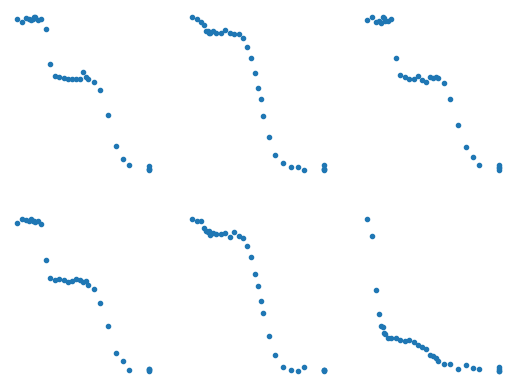

1/1 [==============================] - 0s 76ms/step
[0.     0.0138 0.     0.     0.0136 0.     0.     0.     0.     0.1687 0.     0.     0.     0.     0.     0.093 ] 4
[0.0392 0.0341 0.     0.     0.0278 0.     0.0349 0.     0.     0.1439 0.     0.     0.     0.0204 0.     0.1414] 5
[0.     0.0098 0.     0.     0.0181 0.     0.0013 0.     0.     0.1525 0.     0.     0.     0.     0.     0.0863] 8
[0.     0.0106 0.     0.     0.0194 0.     0.003  0.     0.     0.1515 0.     0.     0.     0.     0.     0.087 ] 8
[0.0375 0.0343 0.     0.     0.0269 0.     0.0337 0.     0.     0.1445 0.     0.     0.     0.019  0.     0.1403] 5
[0.0177 0.0058 0.     0.0098 0.0179 0.0046 0.0188 0.     0.     0.0277 0.     0.     0.     0.0119 0.0044 0.0306] 1


In [13]:
plt.figure()
for n in range(6):
    ax = plt.subplot(2, 3, n + 1)
    plt.plot(rv, x_train[n], '.')
    plt.axis("off")
plt.show()

for x, y in zip(model.backbone.predict(x_train[:6]), y_train[:6]):
    print(x, y)